
# Random Forest Classification for German Poetry Analysis
 
 This notebook implements a Random Forest classifier to analyze German poetry across different centuries.
 Key features:
 - Text preprocessing with TF-IDF vectorization
 - SMOTE for handling class imbalance
 - Random Forest classification with balanced class weights
 - Performance evaluation using confusion matrix and ROC curves
 
 The model aims to classify poems based on their textual features while accounting for temporal variations.


# 🎓 Library

In [1]:
# Data manipulation and analysis
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Text processing
import nltk
import re
from nltk.corpus import stopwords
nltk.download("stopwords")

# Machine learning
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_auc_score,
    roc_curve,
    auc
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec
from sklearn.preprocessing import label_binarize

# Imbalanced learning
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# Utilities
import random
from itertools import cycle
import pickle

# Set random seeds
seed = 42
np.random.seed(seed)
random.seed(seed)

BENCHMARK_TABLE = "../../class_bench.parquet"

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/danedebastos/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# 📚 Loading data into a DataFrame (df)

In [3]:
df = pd.read_parquet("../data/de_poems.parquet")
df = df.astype({"title": "string", "text": "string", "author": "string", "creation": "int64"})
df.dtypes


title       string[python]
text        string[python]
author      string[python]
creation             int64
dtype: object

Get century from creation date

In [4]:
df["century"] = (df["creation"] // 100) + 1

- Clean and preprocess the text data
- Remove stopwords and perform text cleaning
- This will help improve the model's performance by focusing on meaningful words

In [5]:
german_stopwords = set(stopwords.words('german'))

def preprocess(text: str) -> str:
    text = text.lower()
    text = re.sub(r'[\d\W_]+', ' ', text)
    tokens = text.split()
    tokens = [t for t in tokens if t not in german_stopwords]
    return ' '.join(tokens)

df['cleaned_text'] = df['text'].map(preprocess)

In [21]:
df.head()

,title,text,author,creation,century,cleaned_text
0,94.Wieder Geburt,"Gebohrn, und wiederumb, o Mensch, gebohren wer...","Czepko von Reigersfeld, Daniel",1632,17,gebohrn wiederumb o mensch gebohren errettet t...
1,56.Liebe ist der Grund der Welt,"Es suchte niemand Gott, liegt er gleich unterm...","Czepko von Reigersfeld, Daniel",1632,17,suchte niemand gott liegt gleich unterm leben ...
2,7.Gott ergebene Seele,"Die ist in Gott, und Gott der ist zugleich in ...","Czepko von Reigersfeld, Daniel",1632,17,gott gott zugleich leb lebt
3,2.Biß auf den Mund,"Alles, was ich seh an dir, Deiner Stellung, Wo...","Czepko von Reigersfeld, Daniel",1632,17,seh stellung wonn zier wangen freundlich lache...
4,50.Ohne Rache,"Der Weise sucht, ob du ihn hundertmal erschlag...","Czepko von Reigersfeld, Daniel",1632,17,weise sucht hundertmal erschlagen stünd vielma...


Prepare data for Word2Vec model

In [6]:
# Préparation des données pour Word2Vec
sentences = [text.split() for text in df['cleaned_text']]

# Entraînement du modèle Word2Vec
w2v_model = Word2Vec(sentences,
                    vector_size=100,  # Dimension des vecteurs
                    window=5,         # Taille de la fenêtre contextuelle
                    min_count=2,      # Fréquence minimale des mots
                    workers=4,        # Nombre de threads
                    sg=1)            # Skip-gram (1) au lieu de CBOW (0)

# Fonction pour obtenir les vecteurs moyens des documents
def get_document_vectors(texts, model):
    vectors = []
    for text in texts:
        words = text.split()
        word_vectors = [model.wv[word] for word in words if word in model.wv]
        if word_vectors:
            vectors.append(np.mean(word_vectors, axis=0))
        else:
            vectors.append(np.zeros(model.vector_size))
    return np.array(vectors)

# Création des features avec Word2Vec
X_w2v = get_document_vectors(df['cleaned_text'], w2v_model)

# 🤖 Model Classification Construction

In [7]:
X = df['cleaned_text'].values  # Text features
y = df['century'].values       # Target (century)

# Split the data first
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

text_pipeline = ImbPipeline([
    ('tfidf', TfidfVectorizer(max_features=5000, min_df=2,max_df=0.85,ngram_range=(1,2))),
    ('smote', SMOTE(random_state=42)),
    ('classifier', RandomForestClassifier(random_state=42,class_weight='balanced'))
])


In [8]:

# Split des données
X_train_w2v, X_test_w2v, y_train_w2v, y_test_w2v = train_test_split(
    X_w2v, y, test_size=0.2, random_state=42, stratify=y
)

# Création du pipeline avec Word2Vec
w2v_pipeline = ImbPipeline([
    ('smote', SMOTE(random_state=42)),
    ('classifier', RandomForestClassifier(random_state=42, class_weight='balanced'))
])


In [9]:
# Fit the pipeline TF-IDF
text_pipeline.fit(X_train, y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.85, max_features=5000, min_df=2,
                                 ngram_range=(1, 2))),
                ('smote', SMOTE(random_state=42)),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced',
                                        random_state=42))])

In [10]:
# Fit the pipeline Word2Vec
w2v_pipeline.fit(X_train_w2v, y_train_w2v)

Pipeline(steps=[('smote', SMOTE(random_state=42)),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced',
                                        random_state=42))])

In [38]:
# Sauvegarde du modèle TF-IDF
pickle.dump(text_pipeline, open("../trained/random_forest_tfidf.pkl", "wb"))

# Sauvegarde du modèle Word2Vec  
pickle.dump(w2v_pipeline, open("../trained/random_forest_w2v.pkl", "wb"))

print("Les modèles ont été sauvegardés avec succès en format .pkl dans le dossier 'models'")

Les modèles ont été sauvegardés avec succès en format .pkl dans le dossier 'models'


# 📊 Model Evaluation with ROC and Confusion Matrix


Rapport de classification TF-IDF:
              precision    recall  f1-score   support

          11       0.52      0.18      0.27        67
          13       1.00      0.24      0.38        17
          14       0.91      0.57      0.70       198
          16       1.00      0.79      0.88       216
          17       0.84      0.87      0.85      4003
          18       0.78      0.46      0.58      2856
          19       0.74      0.91      0.82      6533
          20       0.61      0.17      0.27       424

    accuracy                           0.78     14314
   macro avg       0.80      0.52      0.59     14314
weighted avg       0.78      0.78      0.76     14314


Rapport de classification w2v:
              precision    recall  f1-score   support

          11       0.55      0.16      0.25        67
          13       1.00      0.29      0.45        17
          14       0.78      0.64      0.71       198
          16       0.99      0.82      0.90       216
          1

<Figure size 1000x800 with 0 Axes>

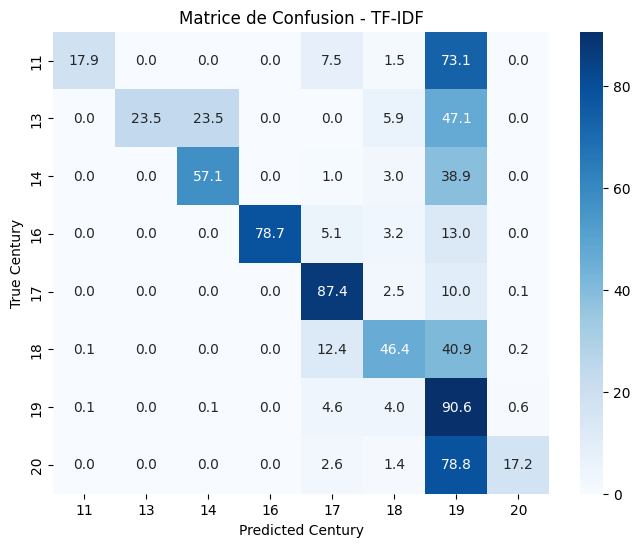

<Figure size 1000x800 with 0 Axes>

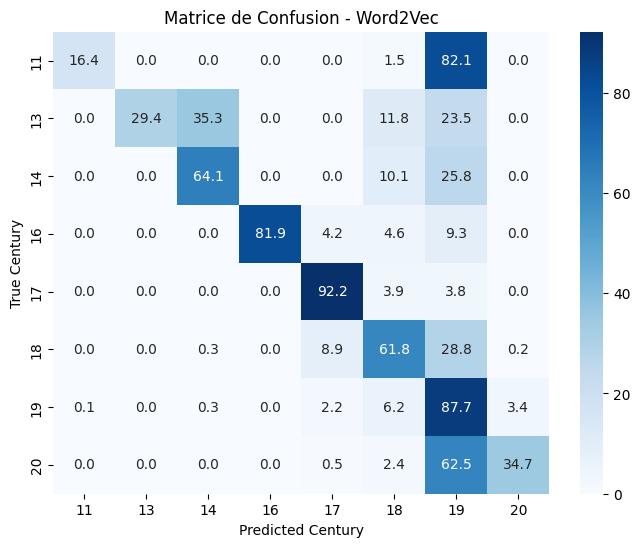

In [11]:
# Évaluation sur l'ensemble de test
y_pred = text_pipeline.predict(X_test)
print("\nRapport de classification TF-IDF:")
tdidf_report = classification_report(y_test, y_pred, output_dict=True)
print(classification_report(y_test, y_pred))

w2v_y_pred = w2v_pipeline.predict(X_test_w2v)
print("\nRapport de classification w2v:")
w2v_report = classification_report(y_test_w2v, w2v_y_pred, output_dict=True)
print(classification_report(y_test_w2v, w2v_y_pred))


# Matrice de confusion pour TF-IDF
plt.figure(figsize=(10, 8))
cm_tfidf = confusion_matrix(y_test, y_pred)
cm_tfidf_percent = cm_tfidf.astype('float') / cm_tfidf.sum(axis=1)[:, np.newaxis] * 100

centuries = sorted(np.unique(np.concatenate((y_test, y_pred))))

plt.figure(figsize=(8,6))
sns.heatmap(cm_tfidf_percent, annot=True, fmt=".1f", cmap='Blues', xticklabels=centuries, yticklabels=centuries)
plt.xlabel('Predicted Century')
plt.ylabel('True Century')
plt.title('Matrice de Confusion - TF-IDF')
plt.show()

# Matrice de confusion pour Word2Vec
plt.figure(figsize=(10, 8))
cm_w2v = confusion_matrix(y_test_w2v, w2v_y_pred)
cm_w2v_percent = cm_w2v.astype('float') / cm_w2v.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(8,6))
sns.heatmap(cm_w2v_percent, annot=True, fmt=".1f", cmap='Blues', xticklabels=centuries, yticklabels=centuries)
plt.xlabel('Predicted Century')
plt.ylabel('True Century')
plt.title('Matrice de Confusion - Word2Vec')
plt.show()

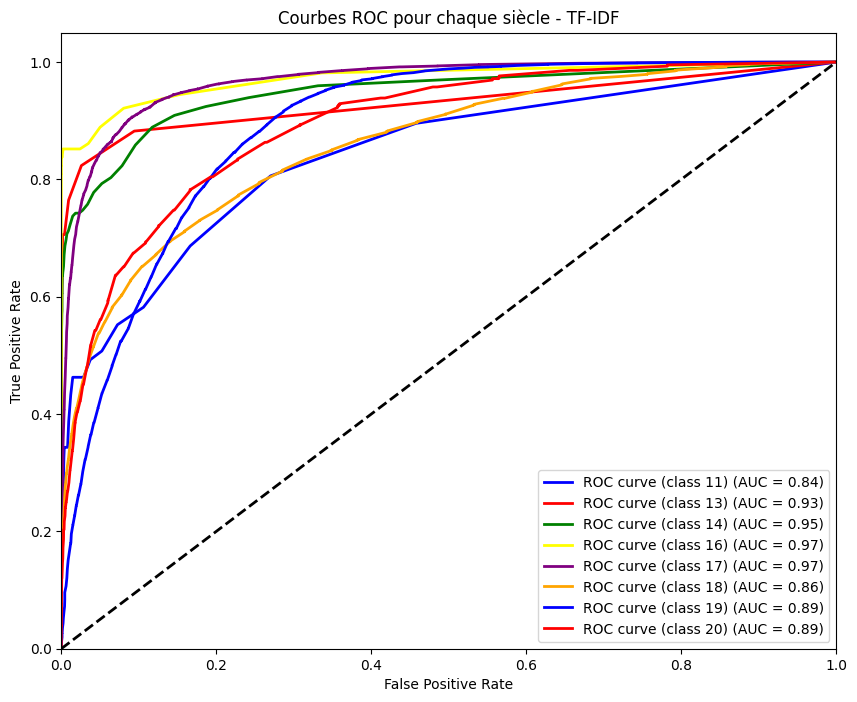


AUC moyenne TF-IDF: 0.913


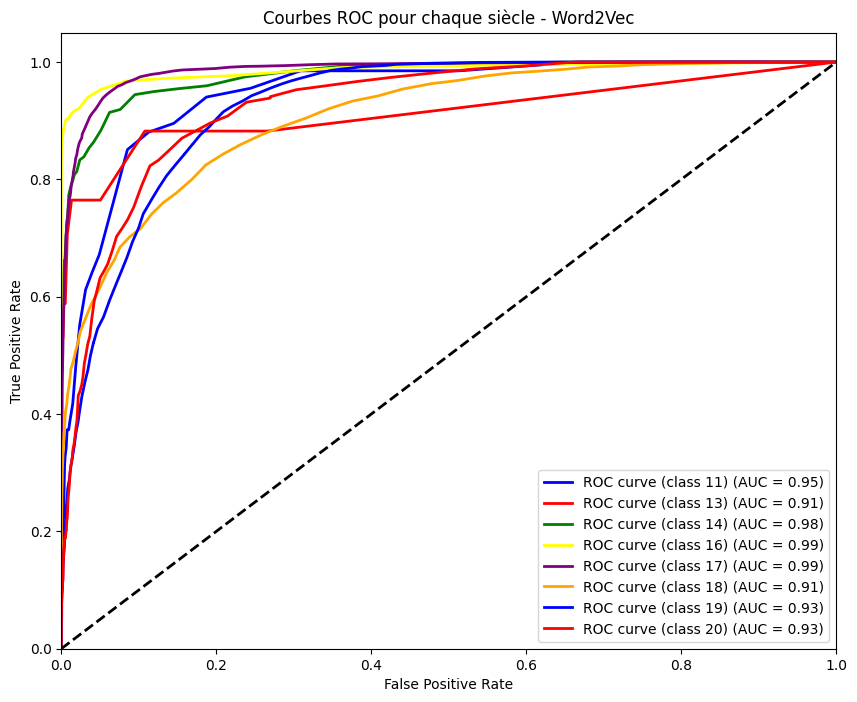


AUC moyenne Word2Vec: 0.947


In [12]:
# Binariser les labels pour la classification multi-classes
classes = np.unique(y)
y_test_bin = label_binarize(y_test, classes=classes)
y_score = text_pipeline.predict_proba(X_test)

# Calculer la courbe ROC et l'AUC pour chaque classe - TF-IDF
plt.figure(figsize=(10, 8))
colors = cycle(['blue', 'red', 'green', 'yellow', 'purple', 'orange'])

for i, color in zip(range(len(classes)), colors):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=color, lw=2,
             label=f'ROC curve (class {classes[i]}) (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Courbes ROC pour chaque siècle - TF-IDF')
plt.legend(loc="lower right")
plt.show()

# Calcul de l'AUC moyenne - TF-IDF
roc_auc = roc_auc_score(y_test_bin, y_score, multi_class='ovr')
print(f"\nAUC moyenne TF-IDF: {roc_auc:.3f}")

# Binariser les labels pour Word2Vec
y_test_w2v_bin = label_binarize(y_test_w2v, classes=classes)
y_score_w2v = w2v_pipeline.predict_proba(X_test_w2v)

# Calculer la courbe ROC et l'AUC pour chaque classe - Word2Vec
plt.figure(figsize=(10, 8))
colors = cycle(['blue', 'red', 'green', 'yellow', 'purple', 'orange'])

for i, color in zip(range(len(classes)), colors):
    fpr, tpr, _ = roc_curve(y_test_w2v_bin[:, i], y_score_w2v[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=color, lw=2,
             label=f'ROC curve (class {classes[i]}) (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Courbes ROC pour chaque siècle - Word2Vec')
plt.legend(loc="lower right")
plt.show()

# Calcul de l'AUC moyenne - Word2Vec
roc_auc_w2v = roc_auc_score(y_test_w2v_bin, y_score_w2v, multi_class='ovr')
print(f"\nAUC moyenne Word2Vec: {roc_auc_w2v:.3f}")



In [13]:
benchmark = pd.read_parquet(BENCHMARK_TABLE)

# Création d'un dictionnaire pour stocker tous les scores
accurency_tfidf = tdidf_report['accuracy']
accurency_w2v = w2v_report['accuracy']
precision_tfidf = tdidf_report['weighted avg']['precision']
precision_w2v = w2v_report['weighted avg']['precision']
recall_tfidf = tdidf_report['weighted avg']['recall']
recall_w2v = w2v_report['weighted avg']['recall']
f1_score_tfidf = tdidf_report['weighted avg']['f1-score']
f1_score_w2v = w2v_report['weighted avg']['f1-score']

benchmark.loc[
    ("Word2Vec", "Random Forest"),
    ["Avg Recall", "Avg F1-Score", "Avg Precision", "Accuracy", "Avg AUC"],
] = [recall_w2v, f1_score_w2v, precision_w2v, accurency_w2v, roc_auc_w2v]

benchmark.loc[
    ("TF-IDF", "Random Forest"),
    ["Avg Recall", "Avg F1-Score", "Avg Precision", "Accuracy", "Avg AUC"],
] = [recall_tfidf, f1_score_tfidf, precision_tfidf, accurency_tfidf, roc_auc]

benchmark.to_parquet(BENCHMARK_TABLE, index=True)

display(benchmark)




Accuracy  Avg Precision  Avg Recall  \
Encoding Model                                                             
TF-IDF   Logistic Regression         0.803689       0.828462    0.803689   
         Feedforward Neural Network  0.870896       0.869331    0.870896   
         Recurrent Neural Network    0.000000       0.000000    0.000000   
         Naive Bayes                 0.000000       0.000000    0.000000   
         Random Forest               0.776513       0.776507    0.776513   
Word2Vec Logistic Regression         0.000000       0.000000    0.000000   
         Feedforward Neural Network  0.000000       0.000000    0.000000   
         Recurrent Neural Network    0.717968       0.793872    0.717968   
         Naive Bayes                 0.000000       0.000000    0.000000   
         Random Forest               0.814028       0.809732    0.814028   
         Multi-Layer Perceptron      0.840506       0.837564    0.840506   

                                     Avg F1-Score   Avg AUC  \
Encoding Model                                                
TF-IDF   Logistic Regression             0.812189  0.969342   
         Feedforward Neural Network      0.868993  0.980472   
         Recurrent Neural Network        0.000000  0.000000   
         Naive Bayes                     0.000000  0.000000   
         Random Forest                   0.759780  0.927325   
Word2Vec Logistic Regression             0.000000  0.000000   
         Feedforward Neural Network      0.000000  0.000000   
         Recurrent Neural Network        0.730375  0.965358   
         Naive Bayes                     0.000000  0.000000   
         Random Forest                   0.809036  0.946552   
         Multi-Layer Perceptron          0.838563  0.983007   

                                     Avg Training time (m)  
Encoding Model                                              
TF-IDF   Logistic Regression                           0.0  
         Feedforward Neural Network                    0.0  
         Recurrent Neural Network                      0.0  
         Naive Bayes                                   0.0  
         Random Forest                                 0.0  
Word2Vec Logistic Regression                           0.0  
         Feedforward Neural Network                    0.0  
         Recurrent Neural Network                      0.0  
         Naive Bayes                                   0.0  
         Random Forest                                 0.0  
         Multi-Layer Perceptron                        0.0